In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reduce memory usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
use_colab = True 

if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    PATH ='/content/drive/MyDrive/'
else:
    PATH='/data/'

Mounted at /content/drive


In [4]:
# Training data
app_train = pd.read_csv(PATH+'app_train_clean.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307506, 249)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


In [5]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307506 entries, 0 to 307505
Columns: 249 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float64(73), int64(176)
memory usage: 584.2 MB


# III Modelisation

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

plt.style.use('fivethirtyeight')

## Preprocessing

On va splitter notre jeu de données en jeux d'entrainement, de validation et de test. Nous allons ensuite tester nos modèles par la suite.

In [7]:
# Sampling
app_train_sample = app_train.sample(10000, random_state=100)
X = app_train_sample.drop(columns = ['TARGET', 'SK_ID_CURR'])
Y = app_train_sample['TARGET']

#X = app_train.drop(columns = ['TARGET', 'SK_ID_CURR'])
#Y = app_train['TARGET']

In [8]:
# Split into train and evaluation set conserving proportions of targets with stratify
Xtrain, Xeval, ytrain, yeval = train_test_split(X, Y, train_size=0.7, random_state=6, stratify=Y)

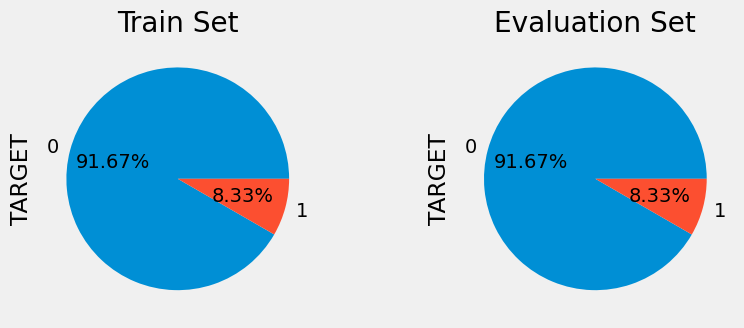

In [9]:
# Display proportion of target value in both train and eval set
fig, ax = plt.subplots(1,2, figsize=(8,4))
ytrain.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set');
yeval.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Evaluation Set');
fig.subplots_adjust(wspace=0.5);

On va remplir les valeurs manquantes dans nos jeux de données avec la médiane pour les colonnes concernées. Pour la normalisation des données, on va utiliser la méthode "MinMaxScaler" qui cale les données numériques entre 0 et 1.

In [10]:
# impute missing values
imputer = SimpleImputer(strategy='median')

imputer.fit(Xtrain)

xtrain = pd.DataFrame(imputer.transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
xeval = pd.DataFrame(imputer.transform(Xeval), index=Xeval.index, columns=Xeval.columns)

In [11]:
# Scale each feature to 0-1
scaler = MinMaxScaler()
scaler.fit(xtrain)

xtrain = pd.DataFrame(scaler.transform(xtrain), index=xtrain.index, columns=xtrain.columns)
xeval = pd.DataFrame(scaler.transform(xeval), index=xeval.index, columns=xeval.columns)

# Testing models

Modèles testés :
- Logistic Regression
- Random Forest Classifier
- Light GBM

Méthodes de rééquilibrage des classes :
- paramètre `class_weight = 'balanced'`
- SMOTE pour augmenter le nombre d'observations de la classe minoritaire
- Undersampling aléatoire pour diminuer le nombre d'observations de la classe majoritaire

Métrique utilisée :
- Fonction de coût personnalisée qui optimise les gains pour la banque (voir ci-dessous)

### Métrique personnalisée

In [12]:
def bank_score(y_true, y_pred):
    
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()
    N = TN + FP    # total negatives cases
    P = TP + FN    # total positives cases
    
    # We set the bank's gain and loss for each case
    FN_value = -10  # The loan is granted but the customer defaults (Type-II Error) 
    TN_value = 1    # The loan is reimbursed
    TP_value = 0    # The loan is (rightly) refused
    FP_value = 0    # Loan is refused by mistake (Type-I Error)

    # calculate total gains
    gain = TP*TP_value + TN*TN_value + FP*FP_value + FN*FN_value
    
    # best score : all observations are correctly predicted
    best = N*TN_value + P*TP_value 

    # baseline : all observations are predicted = 0
    baseline = N*TN_value + P*FN_value 
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain - baseline) / (best - baseline)
    return score

b_score = make_scorer(bank_score)

## 1. Logistic Regression

### A) Baseline

In [13]:
# create model
lr = LogisticRegression()

# prepare table of results
df_scores = pd.DataFrame(index=['Baseline', 'Balanced class_weight', 'Smote', 'Random Undersample'])

We create a function that computes the cross-validation score and returns the probabilities for class 1

In [14]:
def cv_score_sample(model, x, y, scoring, resampling=None, cv=5):
    cv_score = []
    y_pred_proba = []

    # create folds
    kf = KFold(n_splits=cv)
    
    for train_indices, valid_indices in kf.split(x):
        # Training data for the fold
        xtrn, ytrn = x.iloc[train_indices], y.iloc[train_indices]
        # Validation data for the fold
        xval, yval = x.iloc[valid_indices], y.iloc[valid_indices]

        # train
        if resampling is not None :
            # Resample train set
            xtrn_rs, ytrn_rs = resampling.fit_resample(xtrn, ytrn)
            model.fit(xtrn_rs, ytrn_rs)
        
        else:
            model.fit(xtrn, ytrn)

        # predict values on validation set
        ypred = model.predict(xval)
        
        # save probabilities for class 1
        yprob = model.predict_proba(xval)
        y_pred_proba+=(list(yprob[:,1]))

        # save score
        score = round(scoring(yval, ypred),3)
        cv_score.append(score)
    return np.array(cv_score), np.array(y_pred_proba)

In [15]:
cv_score, y_proba = cv_score_sample(lr, xtrain, ytrain, bank_score)

In [16]:
print(cv_score.mean().round(3))

0.026


### Threshold selection

Dans cette fonction, on va selectionner le threshold idéal pour obtenir les 
meilleures performances possibles et voir à partir de quel seuil on obtient 0 ou 1.

On va ensuite utiliser ce seuil sur predict_proba sur le jeu de validation et voir sur la matrice de confusion les différents résultats obtenus ainsi que notre score venant de la fonction de cout pour établir quel modèle est le plus efficace.

De plus, on va observer aussi si SMOTE ou une autre méthode d'echantillonage sont les plus efficaces en termes de performances.

In [17]:
def threshod_selection(Y_proba, Ytrain):
    
    scores = []
    for threshold in np.linspace(0, 1, num=101):
        y_pred = (Y_proba > threshold)*1
        score = bank_score(Ytrain, y_pred)
        scores.append(score)

    scores = np.asarray(scores)
    best_threshold, best_score = (scores.argmax()*.01, round(scores.max(),3))
    print('Best Threshold :', best_threshold)
    print('Best Score :', best_score)

    plt.plot(np.linspace(0, 1, num=101), scores, lw=1)
    plt.axvline(best_threshold, ls='--', lw=1, c='r')
    plt.xlabel('Threshold')
    plt.ylabel('Score performed')
    plt.show()

Best Threshold : 0.1
Best Score : 0.284


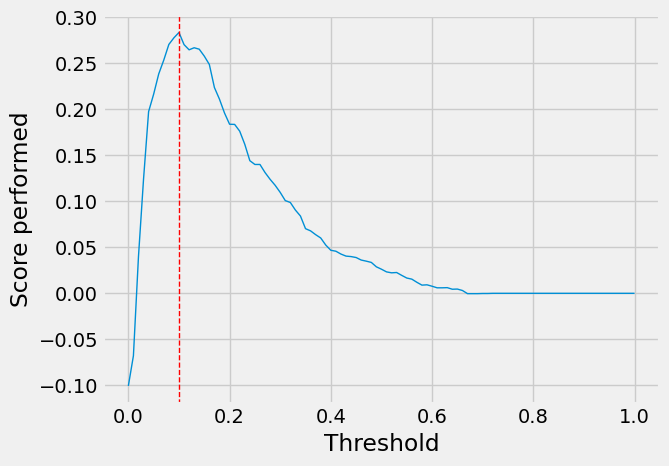

In [18]:
threshod_selection(y_proba, ytrain)

### Predictions and score on evaluation set

In [19]:
def predictions(model, x_train, y_train, x_eval, y_eval, threshold):
    model.fit(x_train, y_train)
    probas = model.predict_proba(x_eval)[:,1]
    predictions = (probas > threshold)*1
    
    # calculate bank_score
    val_score = round(bank_score(y_eval, predictions),3)
    cm=confusion_matrix(y_eval, predictions, normalize='true')*100
        
    # Display score & confusion matrix
    ax = sns.heatmap(cm, annot=True, cmap='RdBu', center=0, cbar=False)
    ax.set_title('Confusion matrix (%)')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
    print(f'Score on Evaluation set with threshold at {threshold} : {val_score}')

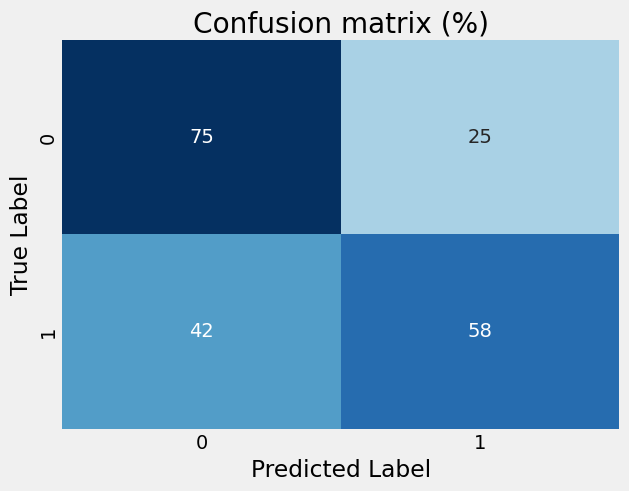

Score on Evaluation set with threshold at 0.1 : 0.31


In [20]:
predictions(lr, xtrain, ytrain, xeval, yeval, threshold = 0.1)

In [21]:
# Save score performed on evaluation set
df_scores.loc['Baseline', 'Logistic Reg'] = 0.31

### B) Avec balanced class_weight

Avec ce paramètre, le modèle réajuste automatiquement le poids des classes 0 et 1 en fonction de leurs fréquences pour obtenir les meilleures performances possibles.


In [22]:
lrb = LogisticRegression(class_weight = 'balanced')

In [23]:
cv_score, y_proba = cv_score_sample(lrb, xtrain, ytrain, bank_score)
print(cv_score.mean().round(3))

0.243


Best Threshold : 0.5700000000000001
Best Score : 0.261


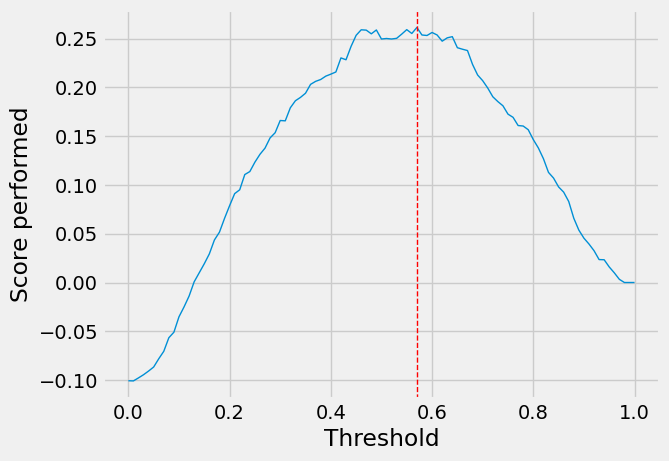

In [24]:
# Threshold selection
threshod_selection(y_proba, ytrain)

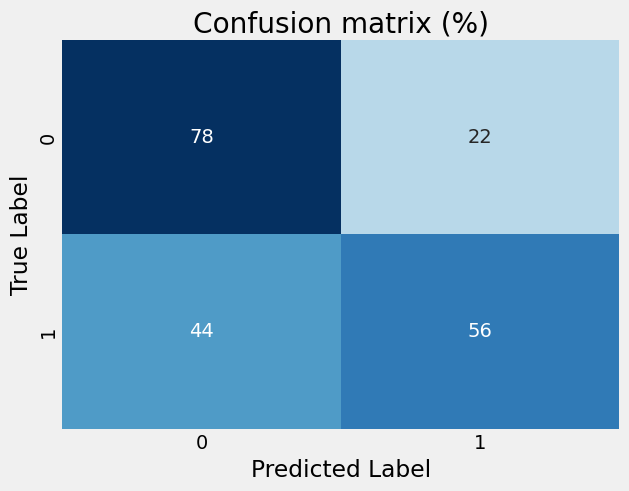

Score on Evaluation set with threshold at 0.57 : 0.318


In [25]:
# Predictions & score on evaluation set
predictions(lrb, xtrain, ytrain, xeval, yeval, threshold = 0.57)

In [26]:
df_scores.loc['Balanced class_weight', 'Logistic Reg'] = 0.318

### C)  Over-sampling de la classe minoritaire avec SMOTE

SMOTE augmente la quantité de classes minoritaires (oversampling) pour obtenir
une observation plus équilibrée.

In [27]:
smote = SMOTE(random_state=42)
xsmot, ysmot = smote.fit_resample(xtrain, ytrain)

In [28]:
print(xtrain.shape, xsmot.shape)

(7000, 247) (12834, 247)


In [29]:
print(Counter(ytrain))
print(Counter(ysmot))

Counter({0: 6417, 1: 583})
Counter({0: 6417, 1: 6417})


In [30]:
cvscore, y_proba = cv_score_sample(lr, xtrain, ytrain, bank_score, resampling=smote)
print(cvscore.mean().round(3))

0.256


Best Threshold : 0.48
Best Score : 0.27


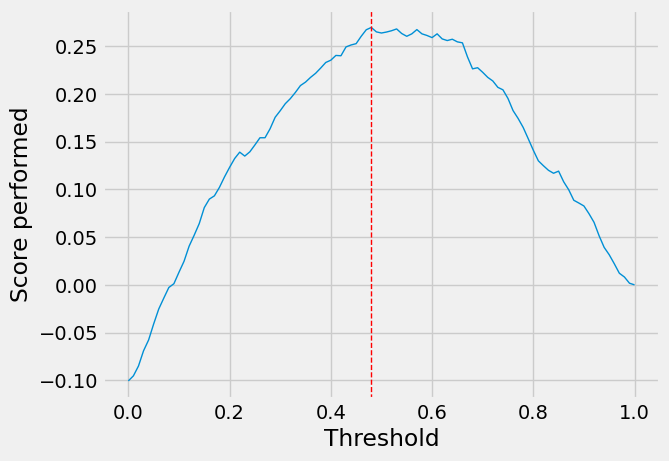

In [31]:
# Threshold selection
threshod_selection(y_proba, ytrain)

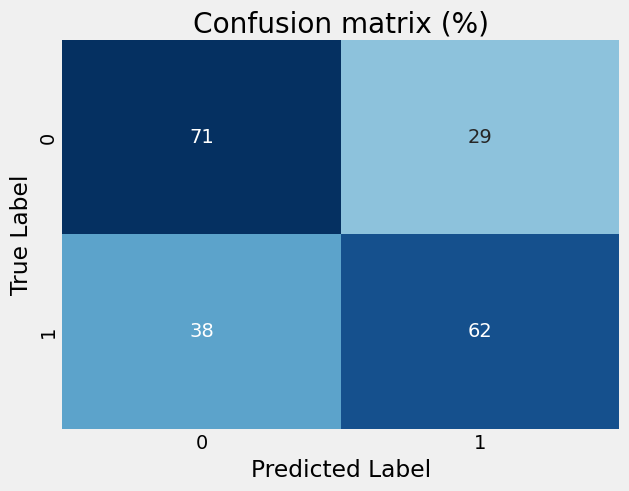

Score on Evaluation set with threshold at 0.48 : 0.298


In [32]:
# Predictions & score on evaluation set
predictions(lr, xsmot, ysmot, xeval, yeval, threshold = 0.48)

In [33]:
df_scores.loc['Smote', 'Logistic Reg'] = 0.298

### D) UnderSampling de classe majoritaire

Ici on effectue un UnderSampling de la classe majoritaire du jeu de données pour réequilibrer les classes 0 et 1.

In [34]:
rus = RandomUnderSampler(random_state=6)
xresampled, yresampled = rus.fit_resample(xtrain, ytrain)

print(Counter(ytrain))
print(Counter(yresampled))

Counter({0: 6417, 1: 583})
Counter({0: 583, 1: 583})


In [35]:
cvscore, y_proba_rus = cv_score_sample(lr, xtrain, ytrain, bank_score, resampling=rus)
print(cvscore.mean().round(3))

0.207


Best Threshold : 0.53
Best Score : 0.222


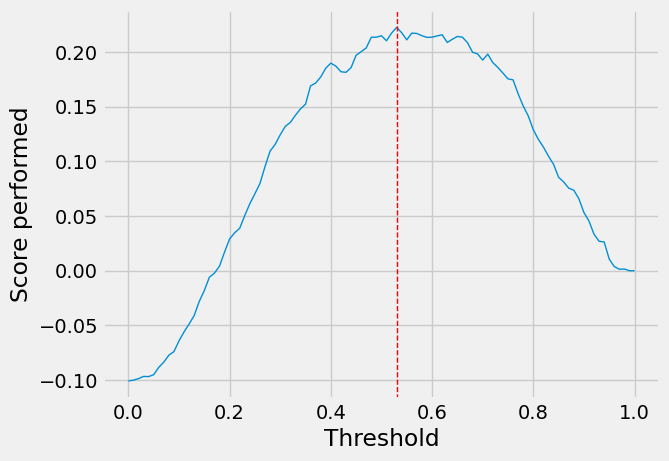

In [36]:
# Threshold selection
threshod_selection(y_proba_rus, ytrain)

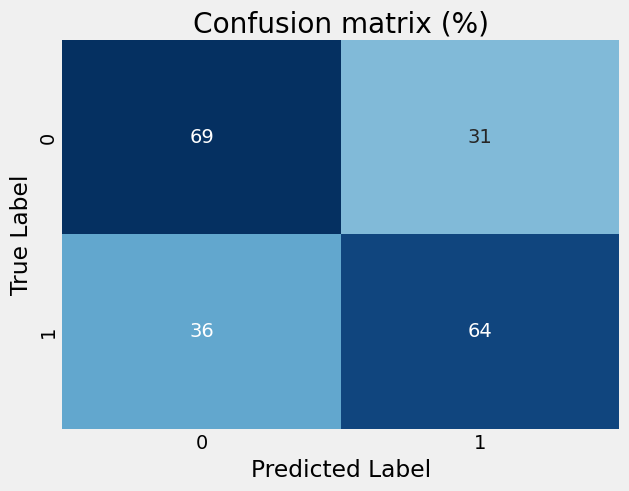

Score on Evaluation set with threshold at 0.53 : 0.3


In [37]:
# Predictions & score on evaluation set
predictions(lr, xresampled, yresampled, xeval, yeval, threshold = 0.53)

In [38]:
df_scores.loc['Random Undersample', 'Logistic Reg'] = 0.3

### Résultats pour la régression logistique

In [39]:
df_scores.sort_values('Logistic Reg', ascending=False)

,Logistic Reg
Balanced class_weight,0.318
Baseline,0.310
Random Undersample,0.300
Smote,0.298


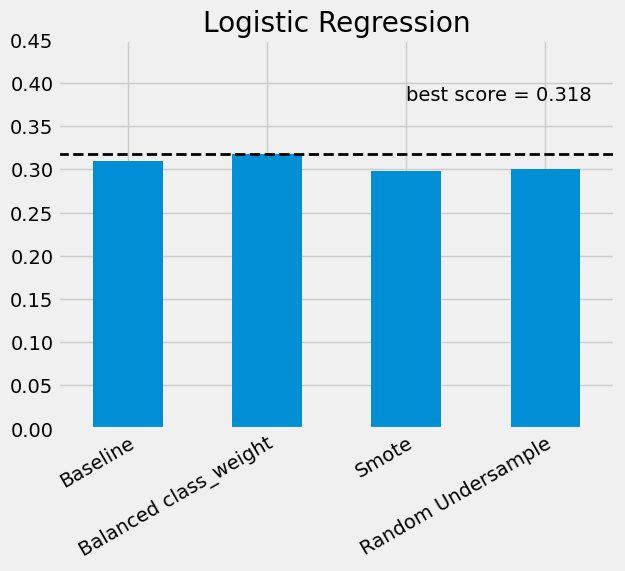

In [40]:
ax = df_scores.plot.bar(legend=None);
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",rotation_mode="anchor");
plt.ylim(0, 0.45);
plt.text(2, 0.38, ('best score = {}'.format(df_scores['Logistic Reg'].max())), color='black');
plt.axhline(df_scores['Logistic Reg'].max(), ls='--', lw=2, c='black');
plt.title('Logistic Regression');

On obtient le meilleur score avec balanced_class_weight et un threshold = 0.57.  

## 2. Random Forest

Après une optimisation des hyperparamètres du modèle RandomForest, pouvant etre utilisé pour une classification,  nous allons tester le modèle avec les memes critères qu'au dessus.

In [41]:
# Grid Search
random_forest = RandomForestClassifier(random_state = 21)

rf_params={ 'class_weight' : ['balanced'],
    'max_features': ['sqrt', None],
    'max_depth': [5, 10, None],
    'min_samples_leaf' : [1, 16, 64]}

rf_random = GridSearchCV(random_forest, rf_params, cv = 5, 
                               scoring = b_score, verbose=200)
rf_random.fit(xtrain, ytrain)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=1
[CV 1/5; 1/18] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=1;, score=0.316 total time=   0.8s
[CV 2/5; 1/18] START class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=1
[CV 2/5; 1/18] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=1;, score=0.241 total time=   0.8s
[CV 3/5; 1/18] START class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=1
[CV 3/5; 1/18] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=1;, score=0.318 total time=   0.8s
[CV 4/5; 1/18] START class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=1
[CV 4/5; 1/18] END class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=1;, score=0.268 total time=   0.8s
[CV 5/5; 1/18] START class_weight=balanced, max_depth=5

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=21),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [5, 10, None],
                         'max_features': ['sqrt', None],
                         'min_samples_leaf': [1, 16, 64]},
             scoring=make_scorer(bank_score), verbose=200)

Ci-dessous on peut voir un tableau montrant les meilleurs hyperparamètres pour notre modèle baseline RandomForest qu'on va pouvoir utiliser par la suite. Cela est fait via GridSearch après avoir splitté le jeu de données en 5 parties(Validation croisée).

In [42]:
rf_cv = pd.DataFrame(rf_random.cv_results_).drop('params',axis=1)
rf_cv.sort_values('mean_test_score', ascending=False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,8.364157,0.460037,0.032076,0.005282,balanced,5,None,64,0.291379,0.312931,0.329060,0.272650,0.342735,0.309751,0.025239,1
4,8.872602,0.593703,0.028089,0.000775,balanced,5,None,16,0.309483,0.273276,0.307692,0.295726,0.346154,0.306466,0.023676,2
2,0.924655,0.151755,0.031706,0.005295,balanced,5,sqrt,64,0.331897,0.254310,0.302564,0.250427,0.387179,0.305276,0.051049,3
8,1.121779,0.224336,0.039827,0.007649,balanced,10,sqrt,64,0.328448,0.256034,0.277778,0.260684,0.376068,0.299803,0.045974,4
0,0.788195,0.014857,0.029404,0.004366,balanced,5,sqrt,1,0.315517,0.240517,0.317949,0.267521,0.346154,0.297532,0.038094,5


### A) Baseline

In [43]:
random_forest = RandomForestClassifier(random_state = 21, 
                                       max_depth = 5, 
                                       max_features = None, 
                                       min_samples_leaf = 64)

In [44]:
cv_score, y_proba = cv_score_sample(random_forest, xtrain, ytrain, bank_score)
print(cv_score.mean().round(3))

0.0


Le score est nul car toutes nos prédictions ont donné 0 ( crédits remboursés).

Best Threshold : 0.09
Best Score : 0.288


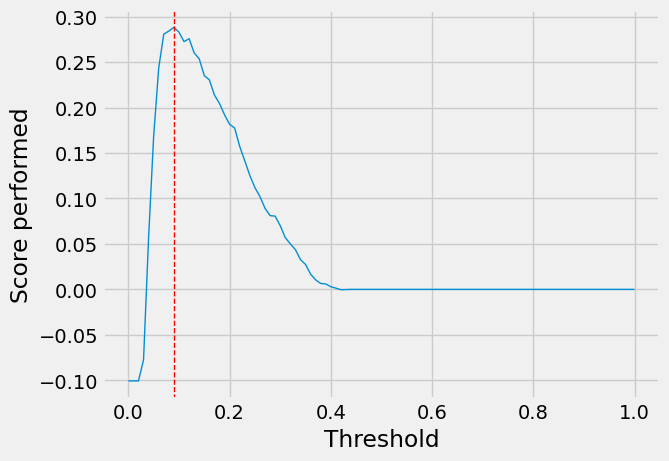

In [45]:
# Threshold selection
threshod_selection(y_proba, ytrain)

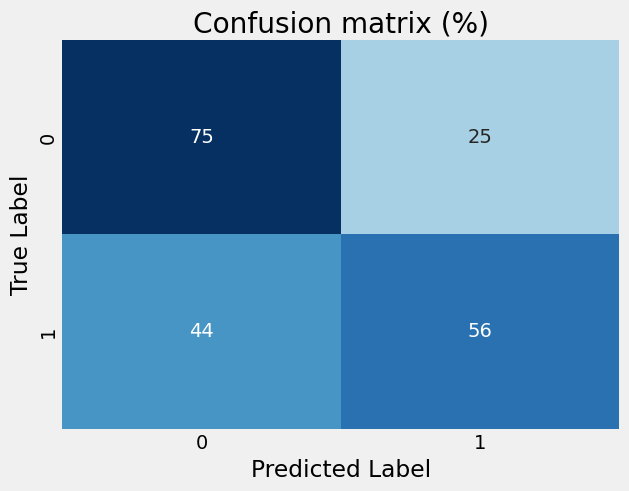

Score on Evaluation set with threshold at 0.09 : 0.284


In [46]:
# Predictions & score on evaluation set
predictions(random_forest, xtrain, ytrain, xeval, yeval, threshold = 0.09)

In [47]:
df_scores.loc['Baseline', 'Random Forest'] = 0.284

### B) balanced class_weight

In [48]:
random_forest_b = RandomForestClassifier(random_state = 21, 
                                         max_depth = 5, 
                                         max_features = None, 
                                         min_samples_leaf = 64,
                                         class_weight = 'balanced')

In [ ]:
cv_score, y_proba = cv_score_sample(random_forest_b, xtrain, ytrain, bank_score)
print(cv_score.mean().round(3))

In [ ]:
# Threshold selection
threshod_selection(y_proba, ytrain)

In [ ]:
# Predictions & score on evaluation set
predictions(random_forest_b, xtrain, ytrain, xeval, yeval, threshold = 0.46)

In [ ]:
df_scores.loc['Balanced class_weight', 'Random Forest'] = 0.318

### C)OverSampling sur la classe minoritaire avec SMOTE

In [ ]:
cv_score, y_proba_smot = cv_score_sample(random_forest, xtrain, ytrain, bank_score, resampling=smote)
print(cv_score.mean().round(3))

In [ ]:
# Threshold selection
threshod_selection(y_proba_smot, ytrain)

In [ ]:
# Predictions & score on evaluation set
predictions(random_forest, xsmot, ysmot, xeval, yeval, threshold = 0.44)

In [ ]:
df_scores.loc['Smote', 'Random Forest'] = 0.167

### D) UnderSampling sur la classe majoritaire

In [ ]:
cv_score, y_proba_rus = cv_score_sample(random_forest, xtrain, ytrain, bank_score, resampling=rus)
print(cv_score.mean().round(3))

In [ ]:
# Threshold selection
threshod_selection(y_proba_rus, ytrain)

In [ ]:
# Predictions & score on evaluation set
predictions(random_forest, xresampled, yresampled, xeval, yeval, threshold = 0.53)

In [ ]:
df_scores.loc['Random Undersample', 'Random Forest'] = 0.285

In [ ]:
df_scores.sort_values('Random Forest', ascending=False)

In [ ]:
ax = df_scores.plot.bar()
plt.title('Performances sur le Val Set')
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",rotation_mode="anchor");
plt.ylim(0, 0.45);
plt.text(2, 0.38, ('best score = {}'.format(df_scores.max().max())), color='black')
plt.axhline(df_scores.max().max(), ls='--', lw=2, c='black');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

#### Le meilleur score est obtenu pour l'undersampling sur Random Forest mais la regression logistique nous donne un meilleur score dans l'ensemble car pour rappel le but est d'obtenir la perte d'argent la plus faible possible pour la banque, d'ou l'importance de notre score.

## 3. Light GBM

Ici on utilise RandomizedSearchCV par souci de temps, le GridSearch prenait trop de temps pour la selection des meilleurs hyperparamètres.

In [ ]:
# Reformating column names
Xtrain.columns = ["".join (c if c.isalnum() else " " for c in str(x)) for x in Xtrain.columns]
Xeval.columns = ["".join (c if c.isalnum() else " " for c in str(x)) for x in Xeval.columns]

In [ ]:
lgbc = lgb.LGBMClassifier()

params = {'class_weight' : ['balanced'],
          'objective' : ['binary'],
          'boosting' : ['gbdt', 'dart', 'goss'],
          'n_estimators': [500], 
          'learning_rate' : [0.01],
          'max_depth' : [5, 10, 20, None],
          'num_leaves' : [4, 16, 64, 128],
          'min_data_in_leaf' : [10, 50, 100, 500]
         }

lgb_random = RandomizedSearchCV(lgbc, params, n_iter = 30, cv = 5, scoring = b_score, verbose=500)

lgb_random.fit(Xtrain, ytrain)

In [ ]:
res = pd.DataFrame(lgb_random.cv_results_).drop('params',axis=1)
res.sort_values('mean_test_score', ascending=False)[:5]

In [ ]:
print(lgb_random.best_score_)
print(lgb_random.best_params_)

### A) Baseline

In [ ]:
lgbc = lgb.LGBMClassifier(objective = 'binary', 
                         num_leaves = 4, 
                         n_estimators = 500, 
                         min_data_in_leaf = 500, 
                         max_depth = None, 
                         learning_rate = 0.01, 
                         #class_weight = 'balanced', 
                         boosting = 'gbdt', 
                         random_state = 21)

In [ ]:
cv_score, y_proba = cv_score_sample(lgbc, Xtrain, ytrain, bank_score)
print(cv_score.mean().round(3))

In [ ]:
# Threshold selection
threshod_selection(y_proba, ytrain)

In [ ]:
# Predictions & score on evaluation set
predictions(lgbc, Xtrain, ytrain, Xeval, yeval, threshold = 0.08)

In [ ]:
df_scores.loc['Baseline', 'Light GBM'] = 0.301

### B) Avec balanced class_weight

In [ ]:
lgbc = lgb.LGBMClassifier(objective = 'binary', 
                         num_leaves = 4, 
                         n_estimators = 500, 
                         min_data_in_leaf = 500, 
                         max_depth = None, 
                         learning_rate = 0.01, 
                         class_weight = 'balanced', 
                         boosting = 'gbdt', 
                         random_state = 21)

In [ ]:
cv_score, y_proba = cv_score_sample(lgbc, Xtrain, ytrain, bank_score)
print(cv_score.mean().round(3))

In [ ]:
# Threshold selection
threshod_selection(y_proba, ytrain)

In [ ]:
# Predictions & score on evaluation set
predictions(lgbc, Xtrain, ytrain, Xeval, yeval, threshold = 0.49)

In [ ]:
df_scores.loc['Balanced class_weight', 'Light GBM'] = 0.315

### D) UnderSampling de la classe majoritaire

In [ ]:
Xrus, yrus = rus.fit_resample(Xtrain, ytrain)

In [ ]:
cv_score, y_proba_rus = cv_score_sample(lgbc, Xtrain, ytrain, bank_score, resampling=rus)
print(cv_score.mean().round(3))

In [ ]:
threshod_selection(y_proba_rus, ytrain)

In [ ]:
# Predictions & score on evaluation set
predictions(lgbc, Xrus, yrus, Xeval, yeval, threshold = 0.5)

In [ ]:
df_scores.loc['Random Undersample', 'Light GBM'] = 0.284

## Résulats finaux

In [ ]:
df_scores

In [ ]:
ax = df_scores.plot.bar()
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",rotation_mode="anchor");
plt.ylim(0, 0.45);
plt.text(2, 0.39, ('best score = {}'.format(df_scores.max().max())), color='b')
plt.axhline(df_scores.max().max(), ls='--', lw=2, c='b');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
plt.title('Scores obtenus sur le val set');

#### Les meilleurs modèles sont LightGBM avec balanced class weight et un threshold donc un seuil égal à 0.49,RandomForest avec un threshold avec un seuil à 0.46, ainsi que la regression Logistique balanced avec un threshold à 0.57;

On va maintenant regarder les features les plus importantes pour Random Forest et pour LightGBM

## Feature Importances

In [ ]:
random_forest_b.fit(xtrain, ytrain)
lgbc.fit(Xtrain, ytrain)

rf_feat_imp = pd.DataFrame(random_forest_b.feature_importances_, index=X.columns, columns=['Random Forest'])
lgb_feat_imp = pd.DataFrame(lgbc.feature_importances_, index=X.columns, columns=['Light GBM'])

In [ ]:
# Plot 10 most important features for Random Forest & Light GBM
fig, ax = plt.subplots(1, 2, figsize=(16,5) )
rf_feat_imp.sort_values('Random Forest')[-10::].plot.barh(ax=ax[0], legend= None);
lgb_feat_imp.sort_values('Light GBM')[-10::].plot.barh(ax=ax[1], color='orange', legend=None);
ax[0].set_title('Random Forest')
ax[1].set_title('Light GBM')
fig.subplots_adjust(wspace=0.5);

In [ ]:
import pickle 
with open('lightgbmfinal.pickle', 'wb') as file :
    pickle.dump(lgbc, file)

# IV Interprétation du modèle avec  SHAP

In [ ]:
pip install shap

In [ ]:
import shap
shap.initjs()

In [ ]:
pickle_out = open(PATH + "lgbmfinal.pkl", "wb")
pickle.dump(lgbc, pickle_out)
pickle_out.close()

In [ ]:
explainer = shap.TreeExplainer(lgbc, model_output = 'probability',
                               data = Xtrain.sample(200),
                              feature_dependence='independent' )
shap_values = explainer.shap_values(Xeval, yeval)

In [ ]:
shap.summary_plot(shap_values, Xeval)

In [ ]:
def ABS_SHAP(df_shap,df):
    
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[227::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6), legend=False)
    ax.set_title("SHAP Value \n valeur en rouge élevée = risque d'impayé")
 

In [ ]:
ABS_SHAP(shap_values, Xeval)

In [ ]:
explainer.expected_value

In [ ]:
Xtrain